<a href="https://colab.research.google.com/github/harnalashok/deeplearning/blob/main/tabular_data_generation_using_gans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -qU scikit-learn

ERROR: allennlp 0.9.0 requires flaky, which is not installed.
ERROR: allennlp 0.9.0 requires responses>=0.7, which is not installed.
ERROR: kmeans-smote 0.1.2 has requirement imbalanced-learn<0.5,>=0.4.0, but you'll have imbalanced-learn 0.6.1 which is incompatible.
ERROR: kmeans-smote 0.1.2 has requirement numpy<1.16,>=1.13, but you'll have numpy 1.18.1 which is incompatible.
ERROR: kmeans-smote 0.1.2 has requirement scikit-learn<0.21,>=0.19.0, but you'll have scikit-learn 0.22.1 which is incompatible.
ERROR: hypertools 0.6.2 has requirement scikit-learn<0.22,>=0.19.1, but you'll have scikit-learn 0.22.1 which is incompatible.
ERROR: allennlp 0.9.0 has requirement spacy<2.2,>=2.1.0, but you'll have spacy 2.2.3 which is incompatible.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score,\
                            accuracy_score, classification_report,\
                            plot_confusion_matrix, confusion_matrix
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

import os
from collections import Counter

np.random.seed(34)
path = '/kaggle/input/creditcardfraud/'

Using TensorFlow backend.


# Data Exploration and Cleaning

In [ ]:
# reading data
df = pd.read_csv(f'{path}creditcard.csv')
df.drop("Time", 1, inplace=True)
print(df.shape)
df.head()

(284807, 30)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
# High class imbalance
df['Class'].value_counts(normalize=True)*100

0    99.827251
1     0.172749
Name: Class, dtype: float64

In [ ]:
# Checking for Null values
print(f"Number of Null values: {df.isnull().any().sum()}")

Number of Null values: 0


In [ ]:
# checking for duplicate values
print(f"Dataset has {df.duplicated().sum()} duplicate rows")
# dropping duplicate rows
df.drop_duplicates(inplace=True)

Dataset has 9144 duplicate rows


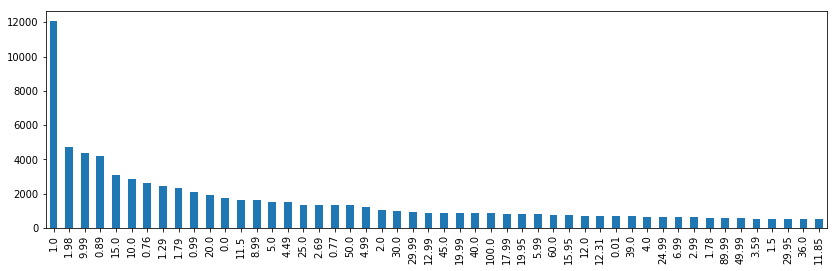

In [ ]:
# high skweness in Amount feature
plt.figure(figsize=(14,4))
df['Amount'].value_counts().head(50).plot(kind='bar')
plt.show()

In [ ]:
# checking skewness of other columns
df.drop('Class',1).skew()

V1        -3.273070
V2        -4.653486
V3        -2.216730
V4         0.681387
V5        -2.458790
V6         1.867576
V7         2.877722
V8        -8.292631
V9         0.550965
V10        1.242165
V11        0.347772
V12       -2.208171
V13        0.061058
V14       -1.953613
V15       -0.295836
V16       -1.048371
V17       -3.802987
V18       -0.255710
V19        0.115957
V20       -2.045060
V21        2.784302
V22       -0.200868
V23       -5.805236
V24       -0.545636
V25       -0.408260
V26        0.587603
V27       -0.745732
V28       11.400938
Amount    16.841622
dtype: float64

In [ ]:
# taking log transform of high positively skewed features
skew_cols = df.drop('Class', 1).skew().loc[lambda x: x>2].index
for col in skew_cols:
    lower_lim = abs(df[col].min())
    normal_col = df[col].apply(lambda x: np.log10(x+lower_lim+1))
    print(f"Skew value of {col} after log transform: {normal_col.skew()}")

Skew value of V7 after log transform: -14.073605361284569
Skew value of V21 after log transform: -19.018195679862643
Skew value of V28 after log transform: -11.293087825590753
Skew value of Amount after log transform: 0.1393219585866376


In [ ]:
# Only applying log transform to Amount feature
df['Amount'] = df['Amount'].apply(lambda x: np.log10(x+1))

In [ ]:
scaler = StandardScaler()
#scaler = MinMaxScaler()
X = scaler.fit_transform(df.drop('Class', 1))
y = df['Class'].values
print(X.shape, y.shape)

(275663, 29) (275663,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

# Training a Baseline Model

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     27520
           1       0.81      0.64      0.71        47

    accuracy                           1.00     27567
   macro avg       0.91      0.82      0.86     27567
weighted avg       1.00      1.00      1.00     27567



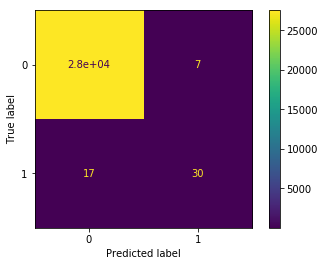

In [ ]:
# simple linear regression
linear_model = LogisticRegression()
linear_model.fit(X_train, y_train)

y_pred = linear_model.predict(X_test)

# evaluation
print(classification_report(y_test, y_pred))
plot_confusion_matrix(linear_model, X_test, y_test)
plt.show()

# Using weighted regression to improve accuracy

In [ ]:
weights = np.linspace(0.05, 0.95, 15)

gscv = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={
        'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    },
    scoring='f1',
    cv=3
)
grid_res = gscv.fit(X, y)

print("Best parameters : %s" % grid_res.best_params_)

Best parameters : {'class_weight': {0: 0.11428571428571428, 1: 0.8857142857142857}}


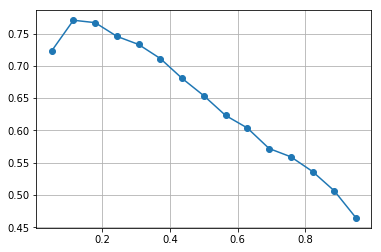

In [ ]:
# plotting F1 scores
plt.plot(weights, grid_res.cv_results_['mean_test_score'], marker='o')
plt.grid()
plt.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     27520
           1       0.73      0.85      0.78        47

    accuracy                           1.00     27567
   macro avg       0.86      0.93      0.89     27567
weighted avg       1.00      1.00      1.00     27567



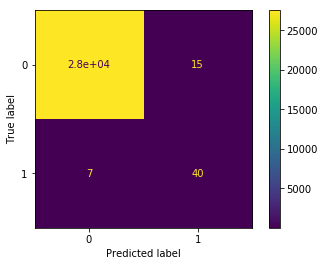

In [ ]:
# training with best weights
wlr = LogisticRegression(**grid_res.best_params_)
wlr.fit(X_train, y_train)

y_pred = wlr.predict(X_test)

# evaluation
print(classification_report(y_test, y_pred))
plot_confusion_matrix(wlr, X_test, y_test)
plt.show()

**Slight improvement when using weighted regression**

# Using SMOTE for upsampling

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     27520
           1       0.06      0.96      0.11        47

    accuracy                           0.97     27567
   macro avg       0.53      0.97      0.55     27567
weighted avg       1.00      0.97      0.98     27567



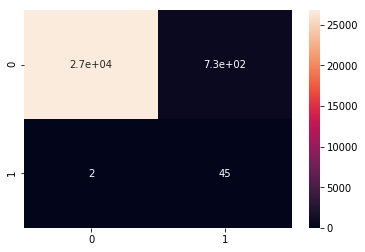

In [ ]:
# constructing pipeline
pipe = Pipeline([
        ('smote', SMOTE()),
        ('lr', LogisticRegression())
])
# training model with smote samples
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

# evaluation
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred),annot=True)
plt.show()

**Poor F1 score even when using SMOTE**

# Grid Search on SMOTE and Regression

In [ ]:
pipe = Pipeline([
        ('smote', SMOTE()),
        ('lr', LogisticRegression())
])
sm_ratio = np.linspace(0.2, 0.8, 10)
lr_weights = np.linspace(0.05, 0.95, 10)

gscv = GridSearchCV(
    estimator=pipe,
    param_grid={
        'smote__sampling_strategy': sm_ratio,
        'lr__class_weight': [{0: x, 1: 1.0-x} for x in lr_weights]
    },
    scoring='f1',
    cv=3
)
grid_result = gscv.fit(X, y)

print("Best parameters : %s" % grid_result.best_params_)

Best parameters : {'lr__class_weight': {0: 0.95, 1: 0.050000000000000044}, 'smote__sampling_strategy': 0.2666666666666667}


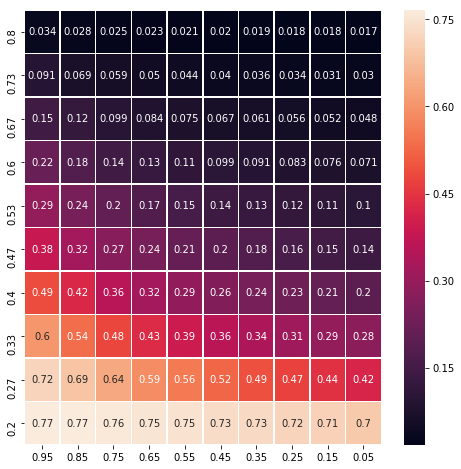

In [ ]:
df_gs = pd.DataFrame(data=grid_result.cv_results_['mean_test_score'].reshape(10,10),
                     index=np.around(sm_ratio[::-1], 2),
                     columns=np.around(lr_weights[::-1], 2))
plt.figure(figsize=(8,8))
sns.heatmap(df_gs,
            annot=True,
            linewidths=.5)
plt.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     27520
           1       0.75      0.85      0.80        47

    accuracy                           1.00     27567
   macro avg       0.88      0.93      0.90     27567
weighted avg       1.00      1.00      1.00     27567



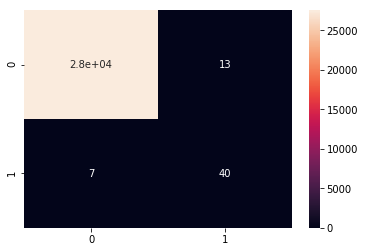

In [ ]:
# training with best weights
pipe = Pipeline([
        ('smote', SMOTE(sampling_strategy= 0.2)),
        ('lr', LogisticRegression(class_weight={0: 0.95, 1: 0.05}))
])
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

# evaluation
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred),annot=True)
plt.show()

**Using SMOTE with weighted regression improves results**

# Using GANs to generate new data

In [ ]:
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.initializers import RandomNormal
import tensorflow.keras.backend as K
from sklearn.utils import shuffle

In [ ]:
class cGAN():
    def __init__(self):
        self.latent_dim = 32
        self.out_shape = 29
        self.num_classes = 2
        self.clip_value = 0.01
        optimizer = Adam(0.0002, 0.5)
        #optimizer = RMSprop(lr=0.00005)

        # build discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        # build generator
        self.generator = self.build_generator()

        # generating new data samples
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        gen_samples = self.generator([noise, label])

        self.discriminator.trainable = False

        # passing gen samples through disc.
        valid = self.discriminator([gen_samples, label])

        # combining both models
        self.combined = Model([noise, label], valid)
        self.combined.compile(loss=['binary_crossentropy'],
                              optimizer=optimizer,
                             metrics=['accuracy'])
        self.combined.summary()

    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def build_generator(self):
        init = RandomNormal(mean=0.0, stddev=0.02)
        model = Sequential()

        model.add(Dense(128, input_dim=self.latent_dim))
        #model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(256))
        #model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(512))
        #model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(self.out_shape, activation='tanh'))
        model.summary()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))

        model_input = multiply([noise, label_embedding])
        gen_sample = model(model_input)

        return Model([noise, label], gen_sample, name="Generator")


    def build_discriminator(self):
        init = RandomNormal(mean=0.0, stddev=0.02)
        model = Sequential()

        model.add(Dense(512, input_dim=self.out_shape, kernel_initializer=init))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Dense(256, kernel_initializer=init))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))

        model.add(Dense(128, kernel_initializer=init))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))

        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        gen_sample = Input(shape=(self.out_shape,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.out_shape)(label))

        model_input = multiply([gen_sample, label_embedding])
        validity = model(model_input)

        return Model(inputs=[gen_sample, label], outputs=validity, name="Discriminator")


    def train(self, X_train, y_train, pos_index, neg_index, epochs, batch_size=32, sample_interval=50):

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            #  Train Discriminator with 8 sample from postivite class and rest with negative class
            idx1 = np.random.choice(pos_index, 8)
            idx0 = np.random.choice(neg_index, batch_size-8)
            idx = np.concatenate((idx1, idx0))
            samples, labels = X_train[idx], y_train[idx]
            samples, labels = shuffle(samples, labels)
            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a half batch of new images
            gen_samples = self.generator.predict([noise, labels])

            # label smoothing
            if epoch < epochs//1.5:
                valid_smooth = (valid+0.1)-(np.random.random(valid.shape)*0.1)
                fake_smooth = (fake-0.1)+(np.random.random(fake.shape)*0.1)
            else:
                valid_smooth = valid
                fake_smooth = fake

            # Train the discriminator
            self.discriminator.trainable = True
            d_loss_real = self.discriminator.train_on_batch([samples, labels], valid_smooth)
            d_loss_fake = self.discriminator.train_on_batch([gen_samples, labels], fake_smooth)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train Generator
            # Condition on labels
            self.discriminator.trainable = False
            sampled_labels = np.random.randint(0, 2, batch_size).reshape(-1, 1)
            # Train the generator
            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)

            # Plot the progress
            if (epoch+1)%sample_interval==0:
                print (f"{epoch} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}] [G loss: {g_loss}]")

In [ ]:
cgan = cGAN()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               15360     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128)               0

In [ ]:
y_train = y_train.reshape(-1,1)
pos_index = np.where(y_train==1)[0]
neg_index = np.where(y_train==0)[0]
cgan.train(X_train, y_train, pos_index, neg_index, epochs=2000)

49 [D loss: 0.6227707266807556, acc.: 0.0] [G loss: [0.6709709, 0.375]]
99 [D loss: 0.30984824895858765, acc.: 0.0] [G loss: [0.76652825, 0.21875]]
149 [D loss: -0.6380395889282227, acc.: 0.0] [G loss: [0.9364205, 0.375]]
199 [D loss: -7.843636989593506, acc.: 0.0] [G loss: [1.0216454, 0.65625]]
249 [D loss: -40.365413665771484, acc.: 0.0] [G loss: [2.550838, 0.375]]
299 [D loss: -68.17256927490234, acc.: 0.0] [G loss: [2.883738, 0.5]]
349 [D loss: -148.5515594482422, acc.: 0.0] [G loss: [3.126454, 0.5625]]
399 [D loss: -202.9923553466797, acc.: 0.0] [G loss: [6.4288263, 0.59375]]
449 [D loss: -251.66151428222656, acc.: 0.0] [G loss: [12.650965, 0.4375]]
499 [D loss: -248.10122680664062, acc.: 0.0] [G loss: [20.565842, 0.5]]
549 [D loss: -772.1979370117188, acc.: 0.0] [G loss: [19.35202, 0.5625]]
599 [D loss: -996.6320190429688, acc.: 0.0] [G loss: [18.185678, 0.59375]]
649 [D loss: -1487.7041015625, acc.: 0.0] [G loss: [33.569443, 0.46875]]
699 [D loss: -3655.150634765625, acc.: 0.0] 

In [ ]:
# generating new samples
noise = np.random.normal(0, 1, (400, 32))
sampled_labels = np.ones(400).reshape(-1, 1)

gen_samples = cgan.generator.predict([noise, sampled_labels])
gen_samples = scaler.inverse_transform(gen_samples)
print(gen_samples.shape)

(400, 29)


In [ ]:
gen_df = pd.DataFrame(data = gen_samples,
                      columns = df.drop('Class',1).columns)
gen_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.510209,-0.037711,1.533052,1.364386,1.365863,1.265051,1.248922,1.184554,1.087182,1.090120,...,0.479415,-0.244902,0.450082,-0.607824,-0.500487,0.516938,0.401964,-0.370998,0.039912,0.698692
1,1.118784,-1.300913,1.533056,1.060768,1.367084,1.284664,1.248932,1.184929,1.087107,1.090136,...,-0.142709,-0.514281,0.636352,-0.624563,-0.551677,0.517290,0.335861,-0.382681,0.091589,0.681268
2,0.098955,0.368017,1.533012,1.404303,1.363878,1.252277,1.248885,1.183168,1.087127,1.090003,...,0.621713,0.000368,0.364308,-0.508717,-0.370661,0.512385,0.419620,-0.363696,-0.006207,0.723382
3,-0.062411,-1.010356,1.533054,1.221316,1.366795,1.282603,1.248931,1.180428,1.087393,1.090135,...,0.487579,-0.644373,0.721080,-0.630989,-0.585784,0.516954,0.368747,-0.364869,0.300230,0.698569
4,0.404423,-0.401513,1.533054,1.366125,1.366835,1.285610,1.248923,1.184297,1.087033,1.090115,...,0.324343,-0.412248,0.454969,-0.606590,-0.459835,0.516152,0.386588,-0.362557,0.010032,0.685057


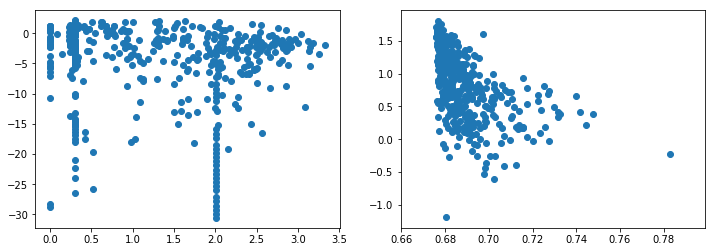

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
ax[0].scatter(df[df['Class']==1]['Amount'], df[df['Class']==1]['V1'])
ax[1].scatter(gen_df['Amount'], gen_df['V1'])
plt.show()